In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   r"C:\Users\saima\OneDrive\Desktop\Garbage-Classification\Week 1\TrashType_Image_Dataset",      
    label_mode='categorical', # For multi-class classification
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\saima\OneDrive\Desktop\Garbage-Classification\Week 1\TrashType_Image_Dataset",      
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
])


In [5]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Freeze for transfer learning


In [6]:
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃                 ┃ Output     ┃ Param ┃
┃ Layer (type)    ┃ Shape      ┃     # ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1   │ (None,     │     0 │
│ (InputLayer)    │ 224, 224,  │       │
│                 │ 3)         │       │
├─────────────────┼────────────┼───────┤
│ sequential      │ (None,     │     0 │
│ (Sequential)    │ 224, 224,  │       │
│                 │ 3)         │       │
├─────────────────┼────────────┼───────┤
│ efficientnetv2… │ (None, 7,  │ 5,91… │
│ (Functional)    │ 7, 1280)   │       │
├─────────────────┼────────────┼───────┤
│ global_average… │ (None,     │     0 │
│ (GlobalAverage… │ 1280)      │       │
├─────────────────┼────────────┼───────┤
│ dropout         │ (None,     │     0 │
│ (Dropout)       │ 1280)      │       │
├─────────────────┼────────────┼───────┤
│ dense (Dense)   │ (None, 6)  │ 7,686 │
└─────────────────┴────────────┴───────┘

 Total params: 5,926,998 (22.61 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]


In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.1860 - loss: 1.8636

64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 752ms/step - accuracy: 0.1868 - loss: 1.8623 - val_accuracy: 0.3703 - val_loss: 1.5756 - learning_rate: 1.0000e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4110 - loss: 1.5269

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.4114 - loss: 1.5263 - val_accuracy: 0.5485 - val_loss: 1.3481 - learning_rate: 1.0000e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5374 - loss: 1.3316

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.5377 - loss: 1.3310 - val_accuracy: 0.6238 - val_loss: 1.1848 - learning_rate: 1.0000e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6317 - loss: 1.1556

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 634ms/step - accuracy: 0.6315 - loss: 1.1556 - val_accuracy: 0.6574 - val_loss: 1.0654 - learning_rate: 1.0000e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6399 - loss: 1.0855

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.6399 - loss: 1.0852 - val_accuracy: 0.6634 - val_loss: 0.9748 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.6807 - loss: 0.9767 

64/64 ━━━━━━━━━━━━━━━━━━━━ 3085s 49s/step - accuracy: 0.6808 - loss: 0.9765 - val_accuracy: 0.6891 - val_loss: 0.9015 - learning_rate: 1.0000e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7049 - loss: 0.9207

64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 666ms/step - accuracy: 0.7048 - loss: 0.9205 - val_accuracy: 0.7109 - val_loss: 0.8421 - learning_rate: 1.0000e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7034 - loss: 0.8848

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.7036 - loss: 0.8844 - val_accuracy: 0.7386 - val_loss: 0.7921 - learning_rate: 1.0000e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7204 - loss: 0.8357

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.7206 - loss: 0.8354 - val_accuracy: 0.7545 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7495 - loss: 0.7693

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 651ms/step - accuracy: 0.7495 - loss: 0.7694 - val_accuracy: 0.7762 - val_loss: 0.7160 - learning_rate: 1.0000e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.7409 - loss: 0.7642 

64/64 ━━━━━━━━━━━━━━━━━━━━ 1508s 24s/step - accuracy: 0.7412 - loss: 0.7638 - val_accuracy: 0.7822 - val_loss: 0.6844 - learning_rate: 1.0000e-04
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7596 - loss: 0.7350

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 650ms/step - accuracy: 0.7597 - loss: 0.7348 - val_accuracy: 0.7901 - val_loss: 0.6564 - learning_rate: 1.0000e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.7788 - loss: 0.7114

64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - accuracy: 0.7788 - loss: 0.7113 - val_accuracy: 0.8059 - val_loss: 0.6323 - learning_rate: 1.0000e-04
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7700 - loss: 0.7032

64/64 ━━━━━━━━━━━━━━━━━━━━ 572s 9s/step - accuracy: 0.7703 - loss: 0.7027 - val_accuracy: 0.8119 - val_loss: 0.6109 - learning_rate: 1.0000e-04
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7664 - loss: 0.6649

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 649ms/step - accuracy: 0.7666 - loss: 0.6647 - val_accuracy: 0.8119 - val_loss: 0.5928 - learning_rate: 1.0000e-04
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7878 - loss: 0.6514

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 641ms/step - accuracy: 0.7879 - loss: 0.6511 - val_accuracy: 0.8198 - val_loss: 0.5750 - learning_rate: 1.0000e-04
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8044 - loss: 0.6080

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - accuracy: 0.8043 - loss: 0.6081 - val_accuracy: 0.8277 - val_loss: 0.5606 - learning_rate: 1.0000e-04
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7997 - loss: 0.6224

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 648ms/step - accuracy: 0.7999 - loss: 0.6219 - val_accuracy: 0.8317 - val_loss: 0.5473 - learning_rate: 1.0000e-04
Epoch 19/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8102 - loss: 0.5851

64/64 ━━━━━━━━━━━━━━━━━━━━ 531s 8s/step - accuracy: 0.8103 - loss: 0.5851 - val_accuracy: 0.8396 - val_loss: 0.5345 - learning_rate: 1.0000e-04
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.7991 - loss: 0.5848

64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 658ms/step - accuracy: 0.7992 - loss: 0.5848 - val_accuracy: 0.8376 - val_loss: 0.5220 - learning_rate: 1.0000e-04


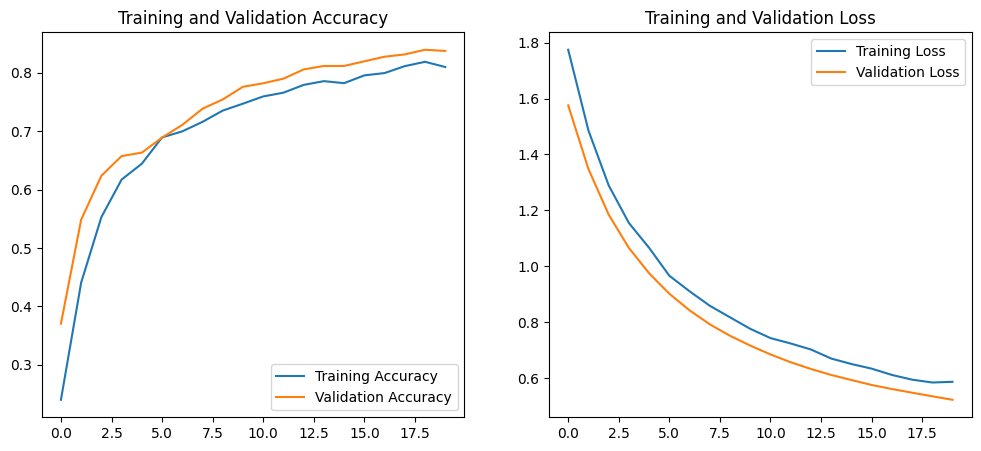

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)


In [10]:
base_model.trainable = True

# Freeze bottom layers — unfreeze top few only (say, last 20 layers)
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 840ms/step - accuracy: 0.7964 - loss: 0.6872 - val_accuracy: 0.8059 - val_loss: 0.6147 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 495s 8s/step - accuracy: 0.7922 - loss: 0.6811 - val_accuracy: 0.8079 - val_loss: 0.5944 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 731ms/step - accuracy: 0.7900 - loss: 0.6648 - val_accuracy: 0.8119 - val_loss: 0.5816 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 714ms/step - accuracy: 0.8056 - loss: 0.6427 - val_accuracy: 0.8198 - val_loss: 0.5685 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 717ms/step - accuracy: 0.7973 - loss: 0.6414 - val_accuracy: 0.8238 - val_loss: 0.5527 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 727ms/step - accuracy: 0.8078 - loss: 0.6032 - val_accuracy: 0.8297 - val_loss: 0.5426 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 709ms/step - accur

64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 732ms/step - accuracy: 0.8115 - loss: 0.5822 - val_accuracy: 0.8238 - val_loss: 0.5131 - learning_rate: 1.0000e-05
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8307 - loss: 0.5395

64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 717ms/step - accuracy: 0.8304 - loss: 0.5399 - val_accuracy: 0.8356 - val_loss: 0.5088 - learning_rate: 1.0000e-05


In [11]:
# Evaluate on val set
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - accuracy: 0.8370 - loss: 0.5012
Validation Accuracy: 83.56%
